
# Convolutional Neural Network CNN
1. Using Glove implementing CNN model
2. Dispaly Confusion Matrix, precision, recall and F1-score
3. Display few prediction using predict module. 
4. Get 10-fold Average of the CNN model.

In [1]:
from __future__ import division, print_function

# dataframe
import pandas as pd

# numpy array
import numpy as np

# figures visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

# word2vec
import gensim 
from gensim import models
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

# CNN model and keras preprocessing
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Conv2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# nltk data preprocessing
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer

# stopword - remove buzz word
from nltk.corpus import stopwords

# splitting data
from sklearn.model_selection import train_test_split

# punctuation - data imbalance
import collections
import re
import string

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

In [2]:
# original english file
filename  = '../../../Data/Real and fake news/news'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.drop(orig_df.columns[[0,1]], axis = 1, inplace = True)
# orig_df.columns = ['Text', 'Label']
orig_df = orig_df.replace(to_replace=['FAKE', 'REAL'], value=[0, 1])

In [3]:
# Run only for English data 
orig_df["text"] = orig_df["text"].astype(str)
orig_df["label"] = orig_df["label"].astype(str)
df = orig_df

In [4]:
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1


### Class count

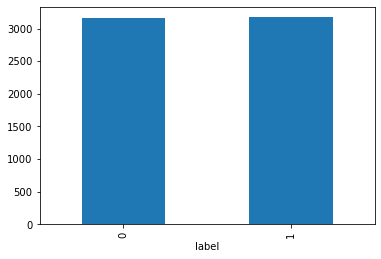

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [6]:
# For entire dataset sentences for each labels 
df.label.value_counts()

1    3171
0    3164
Name: label, dtype: int64

### Balanced Data

In [8]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [9]:
new_text, new_label = balanceClasses(df['text'], df['label'])

In [10]:
data = pd.DataFrame(new_text)
data.columns = ['text']
data['label'] = new_label
data = pd.concat([df, data])

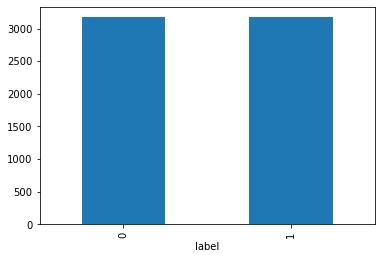

In [11]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [12]:
# For entire dataset sentences for each labels 
data.label.value_counts()

1    3171
0    3170
Name: label, dtype: int64

In [13]:

data=data.sample(frac=1).reset_index(drop=True)
data

,text,label
0,link Donald Trump could have a disability that...,0
1,"SAN JOSE, Calif. —Protests outside a Donald Tr...",1
2,Washington (CNN) The House Benghazi committee ...,1
3,"A white male gunman killed three people, inclu...",1
4,Being Jeb Bush these days means coping with a ...,1
...,...,...
6336,Political parties choose their presidential no...,1
6337,President Barack Obama will not meet with Isra...,1
6338,"by Yves Smith \nBy Wolf Richter, a San Francis...",0
6339,Email \nEven as surveillance hawks such as FBI...,0


### Data Preprocessing

In [14]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceFourColon(x))

In [15]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['text'] = data['text'].apply(lambda x: textPattern(x))

In [16]:
data.shape

(6341, 2)

In [18]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.text]

In [19]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [20]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [21]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [22]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [23]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [27]:
zero  = []
one = []
for l in data.label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        
data['0']= zero
data['1']= one

data = data[['Text_Final', 'tokens', 'label', '0', '1']]

In [28]:
category_id = []
for l in data.label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'label', '0', '1', 'Category_id' ]]
data.head(9)

,Text_Final,tokens,label,0,1,Category_id
0,link donald trump could disability used known ...,"[link, donald, trump, could, disability, used,...",0,1,0,0
1,san jose calif protest outside donald trump ra...,"[san, jose, calif, protest, outside, donald, t...",1,0,1,1
2,washington cnn house benghazi committee took b...,"[washington, cnn, house, benghazi, committee, ...",1,0,1,1
3,white male gunman killed three people includin...,"[white, male, gunman, killed, three, people, i...",1,0,1,1
4,jeb bush day mean coping series petty humiliat...,"[jeb, bush, day, mean, coping, series, petty, ...",1,0,1,1
5,washington c poised give worker city generous ...,"[washington, c, poised, give, worker, city, ge...",1,0,1,1
6,presumably small portion american sat dull deb...,"[presumably, small, portion, american, sat, du...",1,0,1,1
7,argentine president mauricio macri office rebu...,"[argentine, president, mauricio, macri, office...",1,0,1,1
8,donald trump loses election week half poll ind...,"[donald, trump, loses, election, week, half, p...",0,1,0,0


In [29]:
from io import StringIO
category_id_df = data[['label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'label']].values)

#### Split Data into test and train
We will use 90 % data for training and 20 % for testing. We use random state so every time we get the same training and testing data.

In [30]:
data.shape

(6341, 6)

In [31]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)


In [32]:
# # total training words
totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

# # Storing Length of the training sentence
lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

# # training Vocabulary size
trainingVocabSize = sorted(list(set(totalTrainingWords)))

## Total number of lines
linesCount = len(data_train["tokens"])

### Load Google News Glove model

In [33]:
# word2vec_path = 'GoogleNews-vectors-negative300.bin'
# #word2vec_path = 'glove.6B.50d.word2vec'

In [34]:
# from gensim import models
# word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


In [35]:
# Convert Glove file to word2vec format (examples: uses 50 dimensions since it's faster)
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'  # I unzipped in glove.6B subdirectory 
word2vec_output_file = 'glove.6B.300d.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

<ipython-input-35-94d1a7902d0c>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 300)

In [36]:
# Use the converted Glove file


filename = 'glove.6B.300d.word2vec'
word2vec = KeyedVectors.load_word2vec_format(filename, binary=False)


In [37]:
word2vec

In [38]:
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 300


### Tokenize and Pad sequences

In [39]:
tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 57169 unique tokens.


In [40]:
cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [41]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(57170, 300)


In [42]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)

### Define CNN

The model is from the paper 'Convolutional Neural Networks for Sentence Classification' we have updated the network according to our requirement [1]

In [43]:
label_names = ['0', '1']

In [44]:
from tensorflow.keras import optimizers
def ConvolutionalNeuralNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    # Embedding layer
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    
    #Kernal (window) size
    filter_sizes = [2,3,4,5]

    # Convolution Layer and max-pooling
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=512, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis=1)
    
    # softmax layer for multiclass identification 
    x = Dropout(0.1)(l_merge)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss= 'categorical_crossentropy',
                 optimizer = optimizers.RMSprop(learning_rate=1e-3),
#                    optimizer='adam',
                  metrics=['accuracy'])
    return model

In [45]:
# Splitting train data into X_train and y_train
y_train = data_train[label_names].values
x_train = cnnTrainData
y_tr = y_train

In [46]:
# Splitting train data into X_test and y_test
y_test = data_test[label_names].values
x_test = cnnTestData
y_tst = y_test

In [47]:
model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

In [48]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 300)     17151000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 149, 512)     307712      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 148, 512)     461312      embedding[0][0]                  
_______________________________________________________________________________________

### Train CNN

In [49]:
num_epochs = 100
batch_size = 32

In [50]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/100
161/161 [==============================] - 88s 546ms/step - loss: 1.1782 - accuracy: 0.7069 - val_loss: 0.3766 - val_accuracy: 0.8214
Epoch 2/100
161/161 [==============================] - 79s 492ms/step - loss: 0.3532 - accuracy: 0.8545 - val_loss: 0.3471 - val_accuracy: 0.8669
Epoch 3/100
161/161 [==============================] - 83s 515ms/step - loss: 0.2070 - accuracy: 0.9289 - val_loss: 0.3238 - val_accuracy: 0.8897
Epoch 4/100
161/161 [==============================] - 80s 495ms/step - loss: 0.1705 - accuracy: 0.9646 - val_loss: 1.1151 - val_accuracy: 0.8126
Epoch 5/100
161/161 [==============================] - 82s 507ms/step - loss: 0.1517 - accuracy: 0.9698 - val_loss: 1.0068 - val_accuracy: 0.8389
Epoch 6/100
161/161 [==============================] - 94s 582ms/step - loss: 0.1434 - accuracy: 0.9727 - val_loss: 1.1062 - val_accuracy: 0.8546
Epoch 7/100
161/161 [==============================] - 131s 816ms/step - loss: 0.1119 - accuracy: 0.9792 - val_loss: 1.0130 

Epoch 57/100
161/161 [==============================] - 66s 409ms/step - loss: 0.0496 - accuracy: 0.9971 - val_loss: 9.9572 - val_accuracy: 0.8161
Epoch 58/100
161/161 [==============================] - 66s 407ms/step - loss: 0.0542 - accuracy: 0.9982 - val_loss: 4.8267 - val_accuracy: 0.8739
Epoch 59/100
161/161 [==============================] - 66s 407ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 4.9849 - val_accuracy: 0.8739
Epoch 60/100
161/161 [==============================] - 66s 410ms/step - loss: 0.0358 - accuracy: 0.9984 - val_loss: 5.1095 - val_accuracy: 0.8739
Epoch 61/100
161/161 [==============================] - 68s 422ms/step - loss: 0.0439 - accuracy: 0.9973 - val_loss: 5.5140 - val_accuracy: 0.8862
Epoch 62/100
161/161 [==============================] - 67s 413ms/step - loss: 0.0612 - accuracy: 0.9965 - val_loss: 4.6672 - val_accuracy: 0.8914
Epoch 63/100
161/161 [==============================] - 67s 414ms/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 4

In [51]:
# evaluate on test data
results = model.evaluate(x_test, y_tst)

20/20 [==============================] - 3s 152ms/step - loss: 5.1815 - accuracy: 0.8992


In [52]:
# predict model
predictions = model.predict(cnnTestData, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 1ms/step


### Testing few sentences using our model

In [53]:

labels = ['0', '1']

def makeprediction(texts):
    tk = Tokenizer()
    tk.fit_on_texts(texts)
    index_list = tk.texts_to_sequences(texts)
    x_train = pad_sequences(index_list, maxlen=150)
    pred = model.predict(x_train)
    result = labels[np.argmax(pred)]
    return result

In [54]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [56]:
sum(data_test.label==prediction_labels)/len(prediction_labels)

0.8992125984251969

In [57]:
data_test.label.value_counts()

0    324
1    311
Name: label, dtype: int64

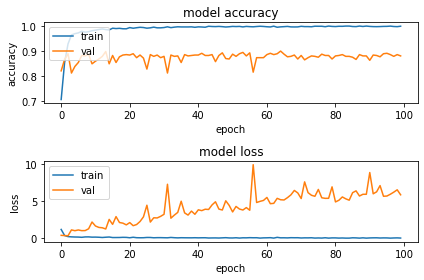

In [58]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [59]:
results = confusion_matrix(data_test.label, prediction_labels)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(data_test.label, prediction_labels))
print ('Report : ')
print (classification_report(data_test.label, prediction_labels))

Confusion Matrix :
[[296  28]
 [ 36 275]]
Accuracy Score : 0.8992125984251969
Report : 
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       324
           1       0.91      0.88      0.90       311

    accuracy                           0.90       635
   macro avg       0.90      0.90      0.90       635
weighted avg       0.90      0.90      0.90       635



                        Convolution Neural Network


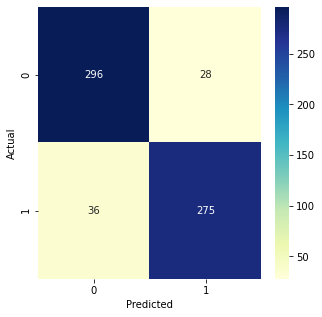

In [60]:
from sklearn.metrics import confusion_matrix
print("                        Convolution Neural Network")
conf_mat = confusion_matrix(data_test.label, prediction_labels)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

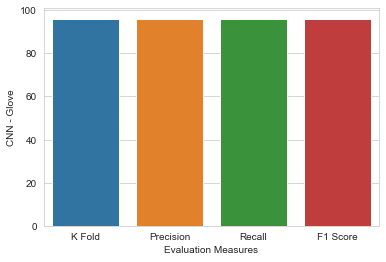

In [61]:
# for Glove
import pandas as pd
import seaborn as sns
results=pd.DataFrame()
dictionary=dict()
dictionary['Evaluation Measures']=["K Fold", "Precision", "Recall", "F1 Score"]
dictionary['CNN - Glove']=[96, 96, 96, 96]
results=pd.DataFrame(dictionary)
sns.set_style(style="whitegrid")
ax = sns.barplot(x='Evaluation Measures', y= 'CNN - Glove',data=results)

### Reference
[1] "Convolutional Neural Networks for Sentence Classification" by Yoon Kim
